In [3]:
#!/usr/bin/env python
# coding: utf-8

# In[1]:


import tensorflow as tf
tf.__version__
tf.config.list_physical_devices('GPU')


# In[20]:


import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os
import logging
import sys
from sklearn import preprocessing
import optuna
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Layer, Reshape, LeakyReLU, BatchNormalization, Dense, Flatten, Input,Dropout
from optuna.trial import TrialState


optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))

study_folder  = '/global/cscratch1/sd/vboehm/OptunaStudies/'
study_name    = "AE_step_two_test_dropout"  # Unique identifier of the study.
study_name    = os.path.join(study_folder, study_name)
storage_name  = "sqlite:///{}.db".format(study_name)
SEED          = 512
EPOCHS        = 5
N_TRIALS      = 10
N_HOURS       = 1

cond_on         = 'type'
fixed_num_bins  = 1000
dim             = fixed_num_bins

optimizers      = {'Adam': tf.keras.optimizers.Adam, 'SGD':tf.keras.optimizers.SGD , 'RMSprop':tf.keras.optimizers.RMSprop}


def dense_cond_block(x,z,num, non_lin=True):
    x = tf.concat([x,z], axis=1)
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return Reshape((num,1))(x)

def dense_block(x,num, non_lin=True):
    x = Flatten()(x)
    x = Dense(num)(x)
    if non_lin:
        x = LeakyReLU()(x)
    return x

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(data, training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}


def make_scheduler(length, initial_lr,factor=1.2):
    def scheduler(epoch, lr):
        if epoch < length:
            lr = initial_lr
            return lr
        else:
            return lr * tf.math.exp(-factor)
    return scheduler
                             
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal, lr_initial, reduce_fac): 
    scheduler = make_scheduler(lr_anneal, lr_initial, reduce_fac)
    callback  = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history   = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_types, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback])
    return history

def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1])])
    return valid_loss


# In[16]:


def objective(trial):
    input        = Input(shape=(dim,1))
    input_mask   = Input(shape=(dim,1))
    input_noise  = Input(shape=(dim,1))
    input_type   = Input(shape=(1,1))
    input_params = Input(shape=(1,1))

    if cond_on=='type':
        z = input_type
    if cond_on=='redshift':
        z = input_params

    n_layers   = trial.suggest_int('n_layers', 2, 4)
    latent_dim = trial.suggest_int('latent_dim', 8, 20)
                                               
    x = input
    out_features = []
    for ii in range(n_layers-1):
        if ii>0:
            out_features.append(trial.suggest_int('n_units_l{}'.format(ii), latent_dim, min(dim,2*out_features[-1])))
            p = trial.suggest_float("dropout_encoder_l{}".format(ii), 1e-4, 0.3, log=True)
            x = Dropout(p)(x)
        else:
            out_features.append(trial.suggest_int('n_units_l{}'.format(ii), latent_dim,dim))
        x = dense_block(x,out_features[ii])
    x = dense_block(x,latent_dim,non_lin=False)
    x = Reshape((latent_dim,1))(x)
    for ii in range(n_layers-1):
        x = dense_cond_block(x,z,out_features[-1-ii])
        if ii ==0:
            pass
        else:
            p = trial.suggest_float("dropout_decoder_l{}".format(ii), 1e-4, 0.3, log=True)
            x = Dropout(p)(x)
    x = dense_cond_block(x,z,dim, non_lin=False)

    lr_initial  = trial.suggest_float("lr_init", 5e-5, 1e-1, log=True)
    lr_end      = trial.suggest_float("lr_final", 5e-6, lr_initial, log=True)
    batchsize   = trial.suggest_int("batchsize", 16, 128)
    decay_steps = trial.suggest_int("decay_steps",500,40000//batchsize*EPOCHS,log=True)
                                               
    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"])
                                        
    learning_rate_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    lr_initial,
    decay_steps,
    lr_end,
    power=0.5, cycle=True)
                                               
    optim = optimizers[optimizer_name]
    
                                               
    lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_type, input_params], outputs=x)
    lstm_ae.compile(optimizer=optim(learning_rate=learning_rate_fn), my_loss=lossFunction, metrics=[],run_eagerly=False)
                                        

    lstm_ae.fit(x=(train['spec'],train['mask'],train['noise'], np.expand_dims(train['subclass'],-1), np.expand_dims(train['z'],-1)), batch_size=batchsize, epochs=EPOCHS, verbose=0)

    res_valid   = lstm_ae.predict((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']))
    recon_error = custom_metric((valid['spec'],valid['mask'],valid['noise'], valid['subclass'], valid['z']),res_valid)
    
    return recon_error



                                               

root_model_data = '/global/cscratch1/sd/vboehm/Datasets/sdss/by_model/'

label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_2         = label+'_minz01_maxz036_minSN50_good'+'_10_fully_connected_mean_div'


train_data = np.load(os.path.join(root_model_data,'train_%s.npy.npz'%label_2))
valid_data = np.load(os.path.join(root_model_data,'valid_%s.npy.npz'%label_2))
test_data  = np.load(os.path.join(root_model_data,'test_%s.npy.npz'%label_2))

keys = ('spec', 'mask', 'noise', 'z', 'RA', 'DE', 'class', 'subclass', 'mean', 'std')

train = {}
for item, key in zip(train_data.files, keys):
    train[key] = train_data[item]


valid = {}
for item, key in zip(valid_data.files, keys):
    valid[key] =  valid_data[item]

test = {}
for item, key in zip(test_data.files, keys):
    test[key] = test_data[item]


le = preprocessing.LabelEncoder()
le.fit(train['subclass'])
train['subclass'] = le.transform(train['subclass'])
valid['subclass'] = le.transform(valid['subclass'])
test['subclass']  = le.transform(test['subclass'])
print(le.classes_, le.transform(le.classes_))                    

time = N_HOURS*60*60-600
study = optuna.create_study(direction='minimize',study_name=study_name, storage=storage_name,load_if_exists=True,  sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))
study.optimize(objective, n_trials=N_TRIALS, timeout=time)


pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


[I 2021-09-30 10:37:56,842] A new study created in RDB with name: /global/cscratch1/sd/vboehm/OptunaStudies/AE_step_two_test_dropout


A new study created in RDB with name: /global/cscratch1/sd/vboehm/OptunaStudies/AE_step_two_test_dropout
A new study created in RDB with name: /global/cscratch1/sd/vboehm/OptunaStudies/AE_step_two_test_dropout
A new study created in RDB with name: /global/cscratch1/sd/vboehm/OptunaStudies/AE_step_two_test_dropout


[I 2021-09-30 10:38:36,291] Trial 0 finished with value: 3.2989803820425525 and parameters: {'n_layers': 2, 'latent_dim': 10, 'n_units_l0': 394, 'lr_init': 0.000802262212160515, 'lr_final': 7.690174362744823e-06, 'batchsize': 53, 'decay_steps': 1291, 'optimizer': 'SGD'}. Best is trial 0 with value: 3.2989803820425525.


Trial 0 finished with value: 3.2989803820425525 and parameters: {'n_layers': 2, 'latent_dim': 10, 'n_units_l0': 394, 'lr_init': 0.000802262212160515, 'lr_final': 7.690174362744823e-06, 'batchsize': 53, 'decay_steps': 1291, 'optimizer': 'SGD'}. Best is trial 0 with value: 3.2989803820425525.
Trial 0 finished with value: 3.2989803820425525 and parameters: {'n_layers': 2, 'latent_dim': 10, 'n_units_l0': 394, 'lr_init': 0.000802262212160515, 'lr_final': 7.690174362744823e-06, 'batchsize': 53, 'decay_steps': 1291, 'optimizer': 'SGD'}. Best is trial 0 with value: 3.2989803820425525.
Trial 0 finished with value: 3.2989803820425525 and parameters: {'n_layers': 2, 'latent_dim': 10, 'n_units_l0': 394, 'lr_init': 0.000802262212160515, 'lr_final': 7.690174362744823e-06, 'batchsize': 53, 'decay_steps': 1291, 'optimizer': 'SGD'}. Best is trial 0 with value: 3.2989803820425525.


[W 2021-09-30 10:39:16,386] Trial 1 failed, because the objective function returned nan.


Trial 1 failed, because the objective function returned nan.
Trial 1 failed, because the objective function returned nan.
Trial 1 failed, because the objective function returned nan.


[W 2021-09-30 10:41:55,132] Trial 2 failed, because the objective function returned nan.


Trial 2 failed, because the objective function returned nan.
Trial 2 failed, because the objective function returned nan.
Trial 2 failed, because the objective function returned nan.


[W 2021-09-30 10:42:18,782] Trial 3 failed, because the objective function returned nan.


Trial 3 failed, because the objective function returned nan.
Trial 3 failed, because the objective function returned nan.
Trial 3 failed, because the objective function returned nan.


[I 2021-09-30 10:44:03,590] Trial 4 finished with value: 6.4338513510648605 and parameters: {'n_layers': 4, 'latent_dim': 15, 'n_units_l0': 509, 'n_units_l1': 458, 'dropout_encoder_l1': 0.1352356598488393, 'n_units_l2': 504, 'dropout_encoder_l2': 0.00016792630588279565, 'dropout_decoder_l1': 0.19566636655053674, 'dropout_decoder_l2': 0.004110686959295227, 'lr_init': 7.433232419307487e-05, 'lr_final': 8.316807135006097e-06, 'batchsize': 50, 'decay_steps': 878, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.2989803820425525.


Trial 4 finished with value: 6.4338513510648605 and parameters: {'n_layers': 4, 'latent_dim': 15, 'n_units_l0': 509, 'n_units_l1': 458, 'dropout_encoder_l1': 0.1352356598488393, 'n_units_l2': 504, 'dropout_encoder_l2': 0.00016792630588279565, 'dropout_decoder_l1': 0.19566636655053674, 'dropout_decoder_l2': 0.004110686959295227, 'lr_init': 7.433232419307487e-05, 'lr_final': 8.316807135006097e-06, 'batchsize': 50, 'decay_steps': 878, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.2989803820425525.
Trial 4 finished with value: 6.4338513510648605 and parameters: {'n_layers': 4, 'latent_dim': 15, 'n_units_l0': 509, 'n_units_l1': 458, 'dropout_encoder_l1': 0.1352356598488393, 'n_units_l2': 504, 'dropout_encoder_l2': 0.00016792630588279565, 'dropout_decoder_l1': 0.19566636655053674, 'dropout_decoder_l2': 0.004110686959295227, 'lr_init': 7.433232419307487e-05, 'lr_final': 8.316807135006097e-06, 'batchsize': 50, 'decay_steps': 878, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.298980

[W 2021-09-30 10:44:56,129] Trial 5 failed, because the objective function returned nan.


Trial 5 failed, because the objective function returned nan.
Trial 5 failed, because the objective function returned nan.
Trial 5 failed, because the objective function returned nan.


[I 2021-09-30 10:45:28,462] Trial 6 finished with value: 41.20318030747512 and parameters: {'n_layers': 3, 'latent_dim': 10, 'n_units_l0': 201, 'n_units_l1': 127, 'dropout_encoder_l1': 0.0006066955110530626, 'dropout_decoder_l1': 0.0006104520415590184, 'lr_init': 0.020942758219036163, 'lr_final': 0.0004331221493607554, 'batchsize': 114, 'decay_steps': 691, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.


Trial 6 finished with value: 41.20318030747512 and parameters: {'n_layers': 3, 'latent_dim': 10, 'n_units_l0': 201, 'n_units_l1': 127, 'dropout_encoder_l1': 0.0006066955110530626, 'dropout_decoder_l1': 0.0006104520415590184, 'lr_init': 0.020942758219036163, 'lr_final': 0.0004331221493607554, 'batchsize': 114, 'decay_steps': 691, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.
Trial 6 finished with value: 41.20318030747512 and parameters: {'n_layers': 3, 'latent_dim': 10, 'n_units_l0': 201, 'n_units_l1': 127, 'dropout_encoder_l1': 0.0006066955110530626, 'dropout_decoder_l1': 0.0006104520415590184, 'lr_init': 0.020942758219036163, 'lr_final': 0.0004331221493607554, 'batchsize': 114, 'decay_steps': 691, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.
Trial 6 finished with value: 41.20318030747512 and parameters: {'n_layers': 3, 'latent_dim': 10, 'n_units_l0': 201, 'n_units_l1': 127, 'dropout_encoder_l1': 0.0006066955110530626, 'dropout_dec

[I 2021-09-30 10:46:37,530] Trial 7 finished with value: 134448.710137647 and parameters: {'n_layers': 4, 'latent_dim': 16, 'n_units_l0': 387, 'n_units_l1': 272, 'dropout_encoder_l1': 0.002157147102888646, 'n_units_l2': 326, 'dropout_encoder_l2': 0.14922667281409283, 'dropout_decoder_l1': 0.28341663511681775, 'dropout_decoder_l2': 0.0014636526044905578, 'lr_init': 0.004848260306319099, 'lr_final': 0.0010691063241320762, 'batchsize': 53, 'decay_steps': 3209, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.2989803820425525.


Trial 7 finished with value: 134448.710137647 and parameters: {'n_layers': 4, 'latent_dim': 16, 'n_units_l0': 387, 'n_units_l1': 272, 'dropout_encoder_l1': 0.002157147102888646, 'n_units_l2': 326, 'dropout_encoder_l2': 0.14922667281409283, 'dropout_decoder_l1': 0.28341663511681775, 'dropout_decoder_l2': 0.0014636526044905578, 'lr_init': 0.004848260306319099, 'lr_final': 0.0010691063241320762, 'batchsize': 53, 'decay_steps': 3209, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.2989803820425525.
Trial 7 finished with value: 134448.710137647 and parameters: {'n_layers': 4, 'latent_dim': 16, 'n_units_l0': 387, 'n_units_l1': 272, 'dropout_encoder_l1': 0.002157147102888646, 'n_units_l2': 326, 'dropout_encoder_l2': 0.14922667281409283, 'dropout_decoder_l1': 0.28341663511681775, 'dropout_decoder_l2': 0.0014636526044905578, 'lr_init': 0.004848260306319099, 'lr_final': 0.0010691063241320762, 'batchsize': 53, 'decay_steps': 3209, 'optimizer': 'Adam'}. Best is trial 0 with value: 3.2989803820

[I 2021-09-30 10:47:17,563] Trial 8 finished with value: 1735040.943575235 and parameters: {'n_layers': 2, 'latent_dim': 19, 'n_units_l0': 831, 'lr_init': 0.021837426815722136, 'lr_final': 0.017952227289354406, 'batchsize': 102, 'decay_steps': 1919, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.


Trial 8 finished with value: 1735040.943575235 and parameters: {'n_layers': 2, 'latent_dim': 19, 'n_units_l0': 831, 'lr_init': 0.021837426815722136, 'lr_final': 0.017952227289354406, 'batchsize': 102, 'decay_steps': 1919, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.
Trial 8 finished with value: 1735040.943575235 and parameters: {'n_layers': 2, 'latent_dim': 19, 'n_units_l0': 831, 'lr_init': 0.021837426815722136, 'lr_final': 0.017952227289354406, 'batchsize': 102, 'decay_steps': 1919, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.
Trial 8 finished with value: 1735040.943575235 and parameters: {'n_layers': 2, 'latent_dim': 19, 'n_units_l0': 831, 'lr_init': 0.021837426815722136, 'lr_final': 0.017952227289354406, 'batchsize': 102, 'decay_steps': 1919, 'optimizer': 'RMSprop'}. Best is trial 0 with value: 3.2989803820425525.


[W 2021-09-30 10:49:06,637] Trial 9 failed, because the objective function returned nan.


Trial 9 failed, because the objective function returned nan.
Trial 9 failed, because the objective function returned nan.
Trial 9 failed, because the objective function returned nan.
Study statistics: 
  Number of finished trials:  10
  Number of pruned trials:  0
  Number of complete trials:  5
Best trial:
  Value:  3.2989803820425525
  Params: 
    batchsize: 53
    decay_steps: 1291
    latent_dim: 10
    lr_final: 7.690174362744823e-06
    lr_init: 0.000802262212160515
    n_layers: 2
    n_units_l0: 394
    optimizer: SGD


In [9]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [10]:
df

,number,value,params_batchsize,params_decay_steps,params_dropout_l1,params_dropout_l2,params_latent_dim,params_lr_final,params_lr_init,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,params_optimizer,state
0,0,2.484652,53,3731,NaN,NaN,10,0.000008,0.000802,2,394,NaN,NaN,SGD,COMPLETE
1,1,2.038530,54,7276,0.045863,NaN,19,0.001153,0.001438,3,807,45.0,NaN,Adam,COMPLETE
2,2,16.155406,76,4089,0.079743,NaN,19,0.000142,0.004290,3,634,321.0,NaN,RMSprop,COMPLETE
3,3,1.664611,30,3675,NaN,NaN,9,0.000036,0.000562,2,407,NaN,NaN,RMSprop,COMPLETE
4,4,36.578362,117,2672,0.218996,0.0307,13,0.000078,0.002269,4,828,831.0,851.0,RMSprop,COMPLETE


(0, 3)

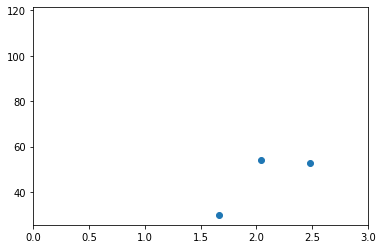

In [11]:
plt.scatter(df['value'], df['params_batchsize'])
plt.xlim(0,3)

In [18]:
from optuna.visualization import plot_contour
from optuna.visualization import plot_edf
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_parallel_coordinate
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_slice

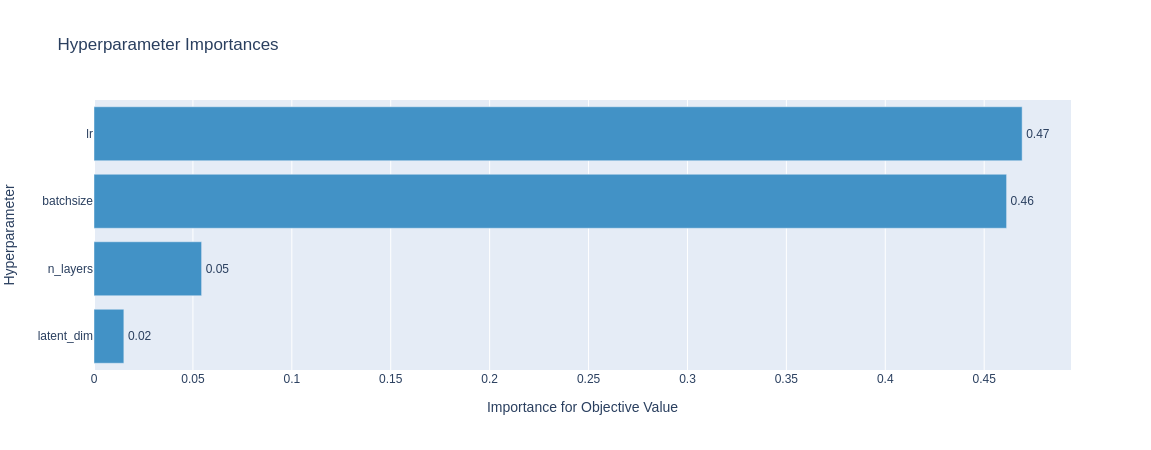

In [19]:
plot_param_importances(study)

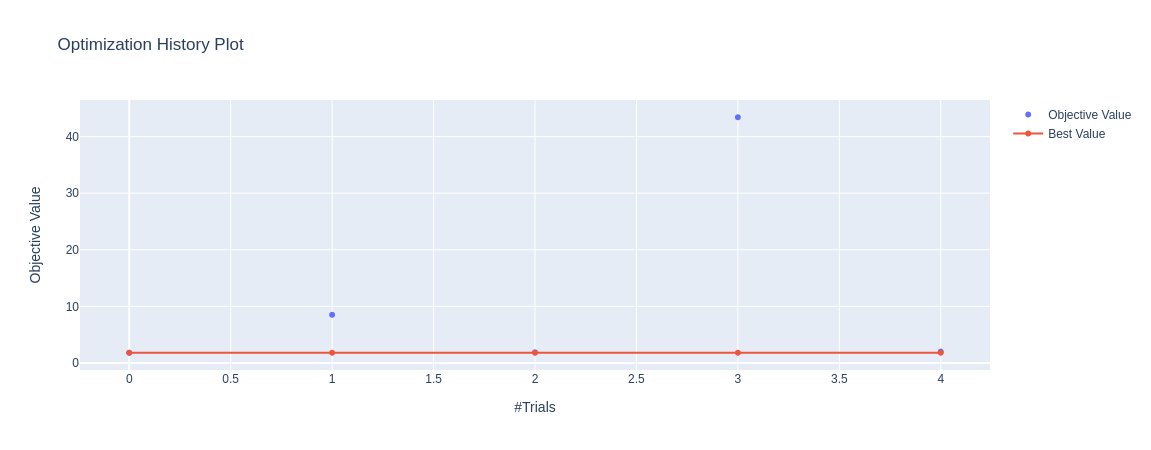

In [9]:
plot_optimization_history(study)

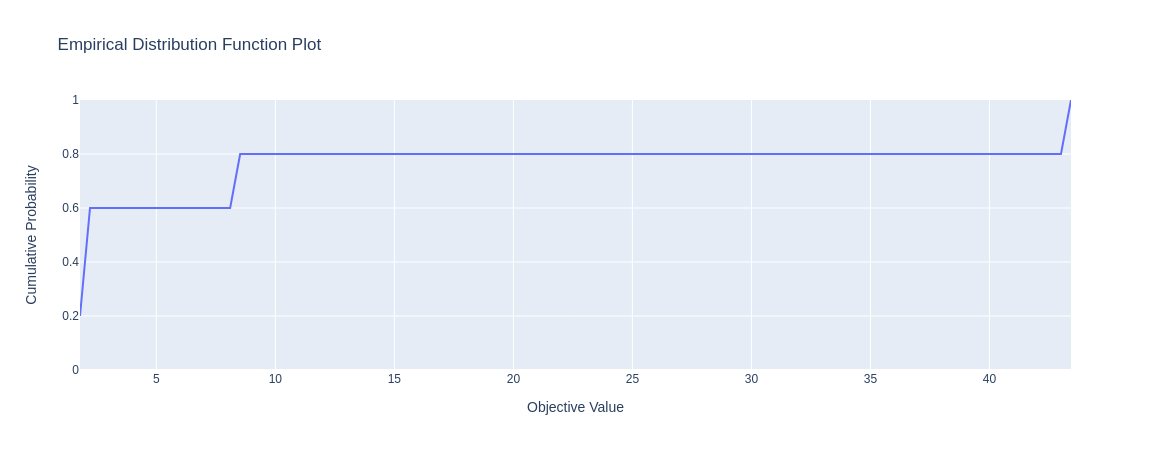

In [10]:
plot_edf(study)

In [11]:
del study

In [12]:
study = optuna.create_study(direction='minimize',study_name=study_name, storage=storage_name,load_if_exists=True,  sampler=optuna.samplers.TPESampler(seed=SEED),
    pruner=optuna.pruners.MedianPruner(n_warmup_steps=10))

[I 2021-09-28 09:42:42,328] Using an existing study with name 'AE_step_one_test' instead of creating a new one.


Using an existing study with name 'AE_step_one_test' instead of creating a new one.


In [13]:
df = study.trials_dataframe(attrs=("number", "value", "params", "state"))

In [14]:
df

,number,value,params_batchsize,params_latent_dim,params_lr,params_n_layers,params_n_units_l0,params_n_units_l1,params_n_units_l2,params_n_units_l3,params_n_units_l4,params_n_units_l5,state
0,0,1.793360,51,4,0.000289,2,390,NaN,NaN,NaN,NaN,NaN,COMPLETE
1,1,8.505263,171,7,0.013452,3,563,266.0,NaN,NaN,NaN,NaN,COMPLETE
2,2,1.866220,57,10,0.000481,7,37,53.0,52.0,101.0,74.0,147.0,COMPLETE
3,3,43.425840,101,7,0.003214,2,895,NaN,NaN,NaN,NaN,NaN,COMPLETE
4,4,1.988593,42,8,0.000016,6,499,539.0,742.0,111.0,202.0,NaN,COMPLETE
